This notebook explores the tweets that official United States Congress member accounts sent from July 21 to October 27, 2017. It merges [tweet data](https://github.com/alexlitel/congresstweets) with [Congress members data](https://github.com/unitedstates/congress-legislators) which contains members' state, political party affiliation and official Twitter handles.

Let's start with importing necessary python libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd

from tqdm import tqdm  
tqdm.pandas(desc="my bar!")

Let's load tweets from json files (one per day) to the notebook. There are almost 200,000 tweets sent in the last two month by official Congress member accounts.

In [2]:
# Load tweets
import glob
tweets = pd.concat(pd.read_json(f) for f in glob.glob('tweets/*.json'))
tweets.head()

print len(tweets)

178739


We are going to analyze the content of each tweet and perform some basic sentiment analysis on whether the tweet is positive, negative or neutral. For sentiment analysis, we use Python natural language processing library [Textblob](https://textblob.readthedocs.io/en/dev/), after cleaning the tweets (ie. removing links, special characters, etc.).

In [3]:
# sentiment analysis 
from textblob import TextBlob
import re
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
 
def get_tweet_sentiment(tweet):
    # create TextBlob object of passed tweet text
    analysis = TextBlob(clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'
    
tweets['sentiment'] = tweets.progress_apply(lambda t: get_tweet_sentiment(t['text']), axis=1)



my bar!: 100%|██████████| 178739/178739 [00:46<00:00, 3876.72it/s]


This is what tweets data look like

In [4]:
tweets.head()

,id,link,screen_name,source,text,time,user_id,sentiment
0,888247233027739648,https://www.twitter.com/RepKevinYoder/statuses...,HouseHomeland,Twitter Web Client,RT @RepKevinYoder Along with last week's passa...,2017-07-21T00:00:17-04:00,239964567,neutral
1,888262367133351936,https://www.twitter.com/tedlieu/statuses/88826...,tedlieu,Twitter for Android,Fun fact: @realDonaldTrump cannot pardon himse...,2017-07-21T01:00:26-04:00,21059255,positive
2,888255408690806784,https://www.twitter.com/DrewPetrimoulx/statuse...,RepCohen,Twitter for iPad,"RT @DrewPetrimoulx ""Every day I have to cry......",2017-07-21T00:32:47-04:00,162069635,neutral
3,888252697031331840,https://www.twitter.com/BigRed_STL/statuses/88...,auctnr1,Twitter for iPhone,RT @BigRed_STL 1974 at the Yale Bowl. #STLCard...,2017-07-21T00:22:00-04:00,21572351,neutral
4,888252666387734528,https://www.twitter.com/BigRed_STL/statuses/88...,auctnr1,Twitter for iPhone,RT @BigRed_STL How many of you went to this pl...,2017-07-21T00:21:53-04:00,21572351,positive


The next step is to load and merge [legislator data](https://github.com/unitedstates/congress-legislators) which contains data in multiple tables for current members of Congress such as their state, party affiliation, Twitter and other social media accounts and their term information.

In [5]:
import yaml
with open('legislators/legislators-district-offices.yaml', 'r') as f:
    districts = pd.io.json.json_normalize(yaml.load(f))
districts.head()

,id.bioguide,id.govtrack,id.thomas,offices
0,A000055,400004,01460,"[{u'city': u'Cullman', u'zip': u'35055', u'lon..."
1,A000360,300002,01695,"[{u'building': u'Tri-Cities Regional Airport',..."
2,A000367,412438,02029,"[{u'city': u'Battle Creek', u'zip': u'49017', ..."
3,A000369,412500,02090,"[{u'city': u'Elko', u'fax': u'775-753-9984', u..."
4,A000370,412607,02201,"[{u'city': u'Charlotte', u'fax': u'704-344-997..."


In [6]:
import yaml

with open('legislators/legislators-social-media.yaml', 'r') as f:
    social = pd.io.json.json_normalize(yaml.load(f))
social.head()

,id.bioguide,id.govtrack,id.thomas,social.facebook,social.instagram,social.instagram_id,social.twitter,social.twitter_id,social.youtube,social.youtube_id
0,R000600,412664,02222,aumuaamata,NaN,NaN,RepAmata,3026622545,NaN,UCGdrLQbt1PYDTPsampx4t1A
1,Y000064,412428,02019,SenatorToddYoung,sentoddyoung,NaN,SenToddYoung,234128524,RepToddYoung,UCuknj4PGn91gHDNAfboZEgQ
2,E000295,412667,02283,senjoniernst,senjoniernst,1582702853,SenJoniErnst,2856787757,NaN,UCLwrmtF_84FIcK3TyMs4MIw
3,T000476,412668,02291,SenatorThomTillis,senthomtillis,NaN,senthomtillis,2964174789,NaN,UCUD9VGV4SSGWjGdbn37Ea2w
4,Y000063,412430,02021,CongressmanKevinYoder,repkevinyoder,NaN,RepKevinYoder,252819642,RepYoder,UCCeYmn4A8kZEHCcAfeUW9lQ


In [7]:

with open('legislators/legislators-current.yaml', 'r') as f:
    current = pd.io.json.json_normalize(yaml.load(f))

legislators = current.merge(social, on='id.bioguide').merge(districts, on='id.bioguide')

legislators.head()


,bio.birthday,bio.gender,bio.religion,family,id.ballotpedia,id.bioguide,id.cspan,id.fec,id.google_entity_id,id.govtrack_x,...,social.facebook,social.instagram,social.instagram_id,social.twitter,social.twitter_id,social.youtube,social.youtube_id,id.govtrack,id.thomas,offices
0,1952-11-09,M,Lutheran,NaN,Sherrod Brown,B000944,5051,"[H2OH13033, S6OH00163]",kg:/m/034s80,400050,...,SenatorSherrodBrown,NaN,NaN,SenSherrodBrown,43910797,SherrodBrownOhio,UCgy8jfERh-t_ixkKKoCmglQ,400050,00136,"[{u'city': u'Cincinnati', u'fax': u'513-684-10..."
1,1958-10-13,F,Roman Catholic,NaN,Maria Cantwell,C000127,26137,"[S8WA00194, H2WA01054]",kg:/m/01x68t,300018,...,senatorcantwell,NaN,NaN,SenatorCantwell,117501995,SenatorCantwell,UCN52UDqKgvHRk39ncySrIMw,300018,00172,"[{u'city': u'Everett', u'fax': u'425-303-8351'..."
2,1943-10-05,M,Jewish,NaN,Ben Cardin,C000141,4004,"[H6MD03177, S6MD03177]",kg:/m/025k3k,400064,...,senatorbencardin,senatorcardin,NaN,SenatorCardin,109071031,senatorcardin,UCiQaJnMzlfzzG3VESgyZChA,400064,00174,"[{u'building': u'Tower 1', u'city': u'Baltimor..."
3,1947-01-23,M,Presbyterian,NaN,Tom Carper,C000174,663,[S8DE00079],kg:/m/01xw7t,300019,...,tomcarper,NaN,NaN,SenatorCarper,249787913,senatorcarper,UCgLnvbKwu4B3navofj6Qvvw,300019,00179,"[{u'city': u'Dover', u'fax': u'302-674-5464', ..."
4,1960-04-13,M,NaN,NaN,"Bob Casey, Jr.",C001070,47036,[S6PA00217],kg:/m/047ymw,412246,...,SenatorBobCasey,senbobcasey,NaN,SenBobCasey,171598736,SenatorBobCasey,UCtVssXhx-KuZa-hSvnsnJ0A,412246,01828,"[{u'city': u'Allentown', u'fax': u'610-782-947..."


For each congress member, let's extract the party and state information from the most recent term.

In [8]:
def most_recent(terms, term_feature):
    terms.sort(key=lambda t: t['end'], reverse=True)
    return terms[0][term_feature]

legislators['party'] = legislators.apply(lambda m: most_recent(m['terms'], 'party'), axis=1)
legislators['state'] = legislators.apply(lambda m: most_recent(m['terms'], 'state'), axis=1)


At the end, this is what we have in legislators data.

In [9]:
legislators.columns

Index([u'bio.birthday', u'bio.gender', u'bio.religion', u'family',
       u'id.ballotpedia', u'id.bioguide', u'id.cspan', u'id.fec',
       u'id.google_entity_id', u'id.govtrack_x', u'id.house_history',
       u'id.icpsr', u'id.lis', u'id.maplight', u'id.opensecrets',
       u'id.thomas_x', u'id.votesmart', u'id.wikidata', u'id.wikipedia',
       u'leadership_roles', u'name.first', u'name.last', u'name.middle',
       u'name.nickname', u'name.official_full', u'name.suffix', u'other_names',
       u'terms', u'id.govtrack_y', u'id.thomas_y', u'social.facebook',
       u'social.instagram', u'social.instagram_id', u'social.twitter',
       u'social.twitter_id', u'social.youtube', u'social.youtube_id',
       u'id.govtrack', u'id.thomas', u'offices', u'party', u'state'],
      dtype='object')

Going back to tweet dataset, let's find the most active Congress members on Twitter.

In [10]:
tweet_counts = tweets['screen_name'].value_counts()
tweet_counts.head()

auctnr1         5545
RepThompson     3063
RepDonBeyer     2135
RepJayapal      1770
RepCloakroom    1590
dtype: int64

Unfortunately, this contains only the Twitter username and the tweet counts. Let's merge the twitter dataset with the legislator dataset to get names, state and party for the Congress members that are highly active on Twitter.

In [11]:
legislators['tweet_count'] = legislators.apply(lambda leg: tweet_counts.get(leg['social.twitter'], 0.), axis=1)

legislators[['name.last', 'name.first', 'tweet_count', 'state', 'party']].sort('tweet_count', ascending=False).head(n=10)


/Library/Python/2.7/site-packages/pandas/core/index.py:805: FutureWarning: scalar indexers for index type Index should be integers and not floating point
  type(self).__name__),FutureWarning)


,name.last,name.first,tweet_count,state,party
290,Thompson,Mike,3063,CA,Democrat
529,Jayapal,Pramila,1770,WA,Democrat
249,Ros-Lehtinen,Ileana,1200,FL,Republican
474,Evans,Dwight,984,PA,Democrat
483,Khanna,Ro,901,CA,Democrat
21,Cornyn,John,859,TX,Republican
27,Merkley,Jeff,840,OR,Democrat
515,Kihuen,Ruben,823,NV,Democrat
391,Castro,Joaquin,820,TX,Democrat
517,Espaillat,Adriano,815,NY,Democrat


Let's look at the Twitter activity on a state level by averaging the number of tweets from congress members on each state. We can see that [Rhode Island](https://www.govtrack.us/congress/members/RI), [Vermont](https://www.govtrack.us/congress/members/VT) and [Washington](https://www.govtrack.us/congress/members/WA) Congress members are the most active ones on average.

In [12]:
tweet_state = legislators.groupby('state')['tweet_count'].mean()

tweet_state.sort('tweet_count', ascending=False)

Let's plot the data over the US map to interactively see states and their Congress members' Twitter activity.

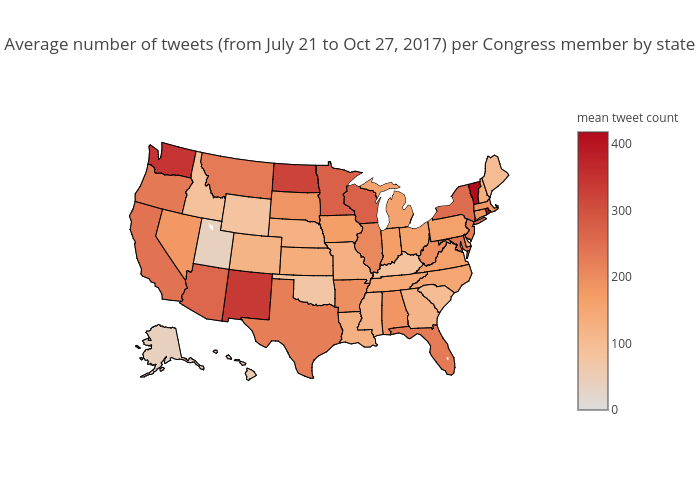

In [36]:
import plotly.plotly as py


data = [ dict(
        type='choropleth',

        locations = tweet_state.index,
        z = tweet_state,
        locationmode = 'USA-states',
        colorbar = dict(
            title = "mean tweet count"
        )
        )]

layout = dict(
        title = 'Average number of tweets (from July 21 to Oct 27, 2017) per Congress member by state',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = go.Figure(data=data, layout=layout)
py.image.save_as(fig, filename='map.png')
from IPython.display import Image
Image('map.png')

When we look at the average tweet count by party, we see that Democrats are much more active than Republicans, but not as much as independent legislators.

In [14]:
legislators.groupby('party')['tweet_count'].mean()

party
Democrat       251.674897
Independent    333.500000
Republican     143.549828
Name: tweet_count, dtype: float64

Finally, let's look at the average sentiment on a given day for Democratic Party and Republican Party.

In [15]:
# sentiment over time by party

tdf = tweets.merge(legislators, left_on='screen_name', right_on='social.twitter')

sentiment_pt = {'positive': 1, 'neutral': 0, 'negative': -1}

tdf['sentiment_pt'] = tdf.apply(lambda t: sentiment_pt[t['sentiment']], axis=1)
tdf['time'] = pd.to_datetime(tdf['time'])
tdf['just_date'] = tdf['time'].dt.date

rep = tdf[tdf['party'] == 'Republican']
dem = tdf[tdf['party'] == 'Democrat']
ind = tdf[tdf['party'] == 'Independent']


Let's plot how the Twitter sentiment changes over time for both political parties.

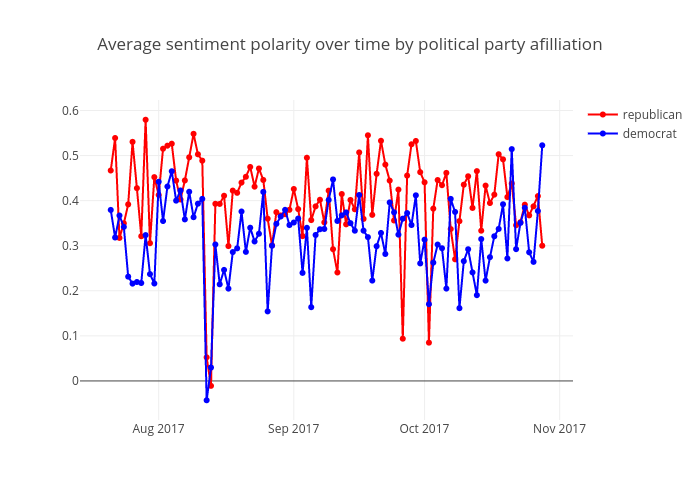

In [37]:
import plotly.graph_objs as go

rep_avg = rep.groupby('just_date', as_index=False)['sentiment_pt'].mean()
dem_avg = dem.groupby('just_date', as_index=False)['sentiment_pt'].mean()
data = [
    go.Scatter(x=rep_avg['just_date'], y=rep_avg['sentiment_pt'], mode='lines+markers', 
               marker={'color': 'red'},
               line={'color': 'red'},
               name="republican"),
    go.Scatter(x=dem_avg['just_date'], y=dem_avg['sentiment_pt'], mode='lines+markers',
               marker={'color': 'blue'},
               line={'color': 'blue'},
               name="democrat"),
]

fig = go.Figure(data=data,
                layout=go.Layout(autosize=True, title='Average sentiment polarity over time by political party afilliation')
                )
py.image.save_as(fig, filename='sentiment.png')
from IPython.display import Image
Image('sentiment.png')

Although the data requires more in-depth analysis, there are few interesting observations we can make. The tweets are usually positive; however, there are significant drops on the average sentiment on particular days.

For example, over the last week of July, we see that a Democratic Congress member tweet is more negative than a Republican Congress member one. The negative Democratic sentiment starts on July 25 when [Senate decided to begin debating health-care legislation](http://www.npr.org/2017/07/25/539334328/senate-scores-narrow-win-in-effort-to-dismantle-affordable-care-act).

There is a very sharp drops on sentiment on August 12th and October 2nd, mostly for both sides which aligns perfectly with [the violance during Charlottesville "Unite the Right" rally](http://www.cnn.com/2017/08/12/us/charlottesville-white-nationalists-rally/index.html) and [Las Vegas shooting](https://en.wikipedia.org/wiki/2017_Las_Vegas_shooting).

Finally, there is a big difference on Sept 26 when [the Senate decided not to vote on the Graham-Cassidy bill to repeal Obamacare](http://www.cnn.com/2017/09/26/politics/health-care-republican-senate-vote/index.html), where average Republican tweet is much more negative than a Democratic one. 